In [1]:
import warnings
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import math
import bisect

sys.path.insert(0, '../../..')

from cde.density_estimator import MixtureDensityNetwork
from cde.data_collector import MatlabDataset, MatlabDatasetH5
from cde.density_estimator import plot_conditional_hist, measure_percentile, measure_percentile_allsame, measure_tail, measure_tail_allsame, init_tail_index_hill, estimate_tail_index_hill


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
""" Open MATLAB file """

#matds = MatlabDataset('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
#matds = MatlabDataset('../../data/dataset_normal_400k.mat')
matds = MatlabDataset('../../data/fulldataset_gamma_400k.mat') 


 Dataset loaded from .mat file. Rows: 399997   Columns: 4 


In [3]:
""" Take conditioned samples and fit density model """

N_tr = 4000

#data = matds.get_data_servicerate_cond([1,1,1])

#data = matds.get_data_firstrows_cond(N_tr)
#train_data = data[0:N_tr,[0,1,3,5]]

train_data = matds.get_data(N_tr)
#train_data = data[0:N_tr,:]

Y = train_data[:,0]
X = train_data[:,1:]

model = MixtureDensityNetwork("GMM_3hop_expar_H", ndim_x=3, n_centers=20, ndim_y=1,n_training_epochs=1000,hidden_sizes=(32, 32))
model.fit(X, Y)

1000/1000 [100%] ██████████████████████████████ Elapsed: 41s | loss: 4110.025
mean log-loss train: 1.0275


In [4]:
""" Save the trained model and the training data into file """

with open('saves/New_3hop_gamma_4k_3dim.pkl', 'wb') as output:
    pickle.dump(model, output, pickle.HIGHEST_PROTOCOL)

np.save('saves/New_ds_gamma_4k_3dim.npy', train_data)

In [3]:
""" Load the trained model and training dataset from file """

dummy = MixtureDensityNetwork("GMM_3hop_expar", ndim_x=2, ndim_y=1)
dummy._setup_inference_and_initialize()

with open('saves/New_3hop_expar_4k_3dim_H.pkl', 'rb') as input:
    dummy = pickle.load(input)

model = dummy

train_data = np.load('saves/New_ds_expar_4k_3dim_H.npy')

 Dataset H5 loaded from .mat file. Rows: 92127736   Columns: 4 


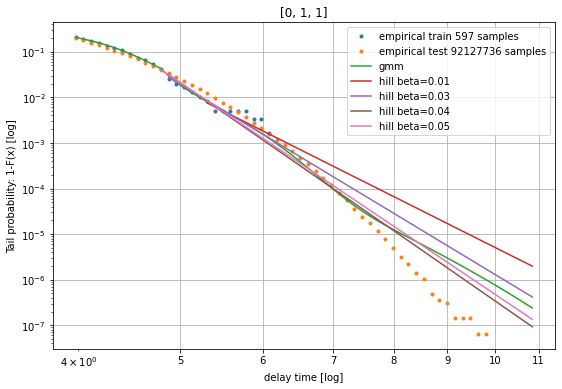

In [20]:
""" Open analysis MATLAB file - [0,1,1] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_1_1]_92M.mat')

cond_state = [0,1,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train)+ " samples", linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test)+ " samples", linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here

hillbetas = [0.01,0.03,0.04,0.05]
for j in range(len(hillbetas)):
    #dsh = matds.get_data(300000)
    hillbeta = hillbetas[j]
    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
    if k == 0:
        continue
    xhill = []
    tailhill=[]
    for i in range(len(x)):
        if x[i]>xk:
            xhill.append(x[i])
            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
    
    ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here


plt.xlabel('delay time [log]')
ax.set_xticks([5,6,7,8,9,10,11])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Tail probability: 1-F(x) [log]')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 65538430   Columns: 4 


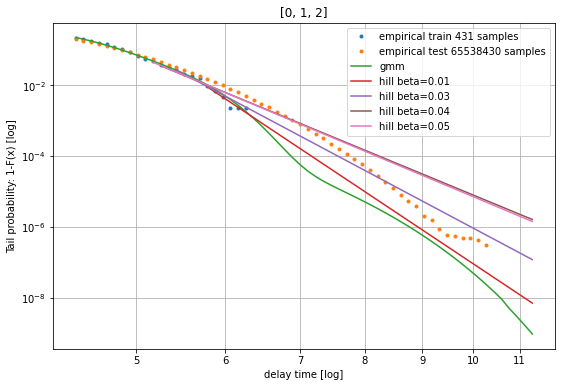

In [21]:
""" Open analysis MATLAB file - [0,1,2] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_1_2]_92M.mat')

cond_state = [0,1,2]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train)+ " samples", linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test)+ " samples", linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here

hillbetas = [0.01,0.03,0.04,0.05]
for j in range(len(hillbetas)):
    #dsh = matds.get_data(300000)
    hillbeta = hillbetas[j]
    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
    if k == 0:
        continue
    xhill = []
    tailhill=[]
    for i in range(len(x)):
        if x[i]>xk:
            xhill.append(x[i])
            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
    
    ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here


plt.xlabel('delay time [log]')
ax.set_xticks([5,6,7,8,9,10,11])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Tail probability: 1-F(x) [log]')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 64248362   Columns: 4 


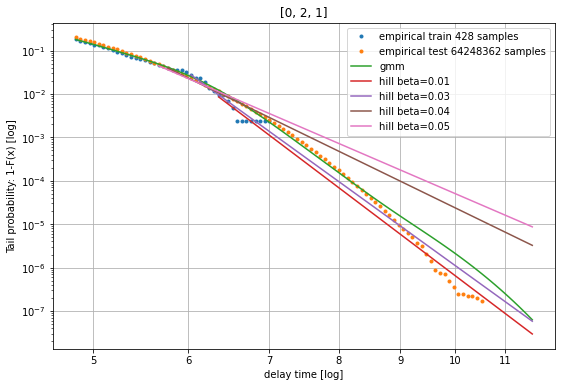

In [19]:
""" Open analysis MATLAB file - [0,2,1] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[0_2_1]_92M.mat')

cond_state = [0,2,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=100)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train)+ " samples", linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test)+ " samples", linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here

hillbetas = [0.01,0.03,0.04,0.05]
for j in range(len(hillbetas)):
    #dsh = matds.get_data(300000)
    hillbeta = hillbetas[j]
    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
    if k == 0:
        continue
    xhill = []
    tailhill=[]
    for i in range(len(x)):
        if x[i]>xk:
            xhill.append(x[i])
            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
    
    ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here


plt.xlabel('delay time [log]')
ax.set_xticks([5,6,7,8,9,10,11])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Tail probability: 1-F(x) [log]')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 55503665   Columns: 4 


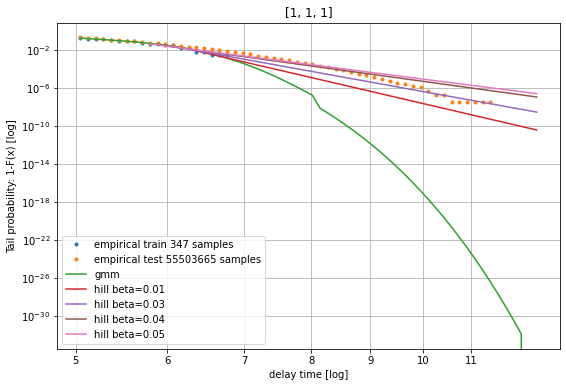

In [22]:
""" Open analysis MATLAB file - [1,1,1] state """

#matds = MatlabDatasetH5('../../data/t3_0p5_1_1p5_cap_30_ar0p8.mat') 
cond_matds = MatlabDatasetH5('../../data/cond_records_[1_1_1]_92M.mat')

cond_state = [1,1,1]
test_data = cond_matds.get_data(cond_matds.n_records)

tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=60)
#x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
#print(x)

tail=[]
for i in range(len(x)):
    tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

testd_sorted = np.sort(test_data[:,0])
ftail=[]
for i in range(len(x)):
    indx = bisect.bisect_left(testd_sorted, x[i])
    ftail.append((len(test_data)-indx)/len(test_data))

#xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
tailh=[]
for i in range(len(x)):
    tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train)+ " samples", linestyle = 'None') #substitute actual plotting here
ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test)+ " samples", linestyle = 'None') #substitute actual plotting here
ax.loglog(x,tailh, label="gmm") #substitute actual plotting here

hillbetas = [0.01,0.03,0.04,0.05]
for j in range(len(hillbetas)):
    #dsh = matds.get_data(300000)
    hillbeta = hillbetas[j]
    alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
    if k == 0:
        continue
    xhill = []
    tailhill=[]
    for i in range(len(x)):
        if x[i]>xk:
            xhill.append(x[i])
            tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
    
    ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here


plt.xlabel('delay time [log]')
ax.set_xticks([5,6,7,8,9,10,11])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylabel('Tail probability: 1-F(x) [log]')
plt.title(str(cond_state))
plt.legend()
plt.grid()
plt.show()

 Dataset H5 loaded from .mat file. Rows: 92127736   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 65538430   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 64248362   Columns: 4 
 Dataset H5 loaded from .mat file. Rows: 55503665   Columns: 4 


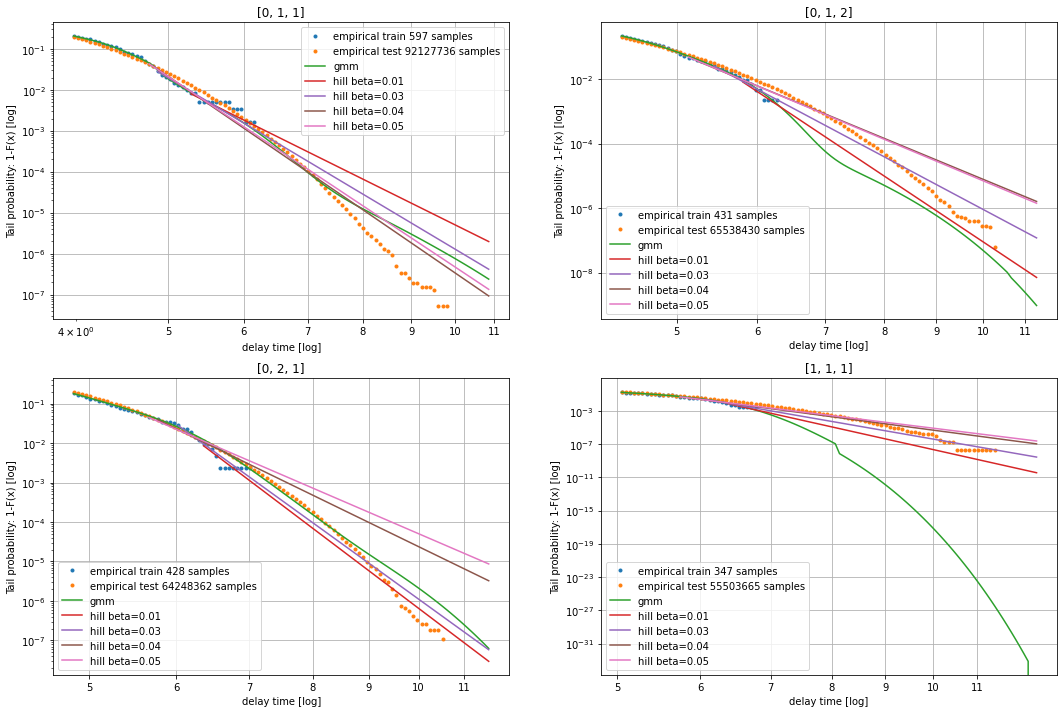

In [29]:
""" Open analysis MATLAB file - [1,1,1] state """

cond_matds_ar = []
cond_matds_ar.append(MatlabDatasetH5('../../data/cond_records_[0_1_1]_92M.mat'))
cond_matds_ar.append(MatlabDatasetH5('../../data/cond_records_[0_1_2]_92M.mat'))
cond_matds_ar.append(MatlabDatasetH5('../../data/cond_records_[0_2_1]_92M.mat'))
cond_matds_ar.append(MatlabDatasetH5('../../data/cond_records_[1_1_1]_92M.mat'))

cond_state_arr = [[0,1,1],[0,1,2],[0,2,1],[1,1,1]]

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(9*2,6*2))

for n in range(len(cond_state_arr)):
    ax = axs[int(n/2),n%2]
    test_data = cond_matds_ar[n].get_data(cond_matds_ar[n].n_records)
    cond_state = cond_state_arr[n]

    tt,num_samples_train,avg = measure_percentile(dataset=train_data,x_cond=np.array([cond_state]),p_perc=100)
    measured_p8,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=80)
    measured_1,num_samples_test,avg = measure_percentile_allsame(dataset=test_data,p_perc=100)
    x = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+1), num=100)
    #x = np.arange(start=measured_p8, stop=measured_1, step=0.1)
    #print(x)

    tail=[]
    for i in range(len(x)):
        tail.append(measure_tail(dataset=train_data,x_cond=np.array([cond_state]),y=x[i]))

    testd_sorted = np.sort(test_data[:,0])
    ftail=[]
    for i in range(len(x)):
        indx = bisect.bisect_left(testd_sorted, x[i])
        ftail.append((len(test_data)-indx)/len(test_data))

    #xh = np.logspace(math.log10( measured_p8 ), math.log10( measured_1+40 ), num=40)
    tailh=[]
    for i in range(len(x)):
        tailh.append(model.find_tail(x_cond=np.array([cond_state]),y=x[i],init_bound=500))

    
    ax.loglog(x,tail, marker='.', label="empirical train "+str(num_samples_train)+ " samples", linestyle = 'None') #substitute actual plotting here
    ax.loglog(x,ftail, marker='.', label="empirical test "+str(num_samples_test)+ " samples", linestyle = 'None') #substitute actual plotting here
    ax.loglog(x,tailh, label="gmm") #substitute actual plotting here

    hillbetas = [0.01,0.03,0.04,0.05]
    for j in range(len(hillbetas)):
        #dsh = matds.get_data(300000)
        hillbeta = hillbetas[j]
        alpha,xk,k,n = init_tail_index_hill(dataset=train_data,x_cond=np.array([cond_state]),beta=hillbeta)
        if k == 0:
            continue
        xhill = []
        tailhill=[]
        for i in range(len(x)):
            if x[i]>xk:
                xhill.append(x[i])
                tailhill.append(estimate_tail_index_hill(alpha=alpha,xk=xk,k=k,n=n,x=x[i]))
        
        ax.loglog(xhill,tailhill, label="hill beta="+str(hillbeta)) #substitute actual plotting here


    ax.set_xlabel('delay time [log]')
    ax.set_xticks([5,6,7,8,9,10,11])
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_ylabel('Tail probability: 1-F(x) [log]')
    ax.set_title(str(cond_state))
    ax.legend()
    ax.grid()

plt.show()
